# **Cookie Cats**
— это популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «три вряд».

По мере прохождения уровней игры игроки будут время от времени сталкиваться с воротами(gate), которые заставят их ждать некоторое количество времени или совершать покупки в приложении для прохождения. Помимо стимулирования покупок в приложении, эти ворота служат важной цели, давая игрокам принудительный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия игрока от игры.

Но где должны быть расположены ворота? Изначально первые ворота располагались на уровне 30, но в этом блокноте я собираюсь проанализировать AB-тест, в котором переместили первые ворота в Cookie Cats с уровня 30 на уровень 40. В частности, я рассмотрю влияние на удержание игроков. Но прежде чем я доберусь до этого, ключевым шагом перед проведением любого анализа является понимание данных.

---

Этот набор данных включает результаты A/B-тестирования игры Cookie Cats для изучения того, что происходит, когда первые ворота в игре перемещаются с уровня 30 на уровень 40. Когда игрок устанавливал игру, он или она были случайным образом назначены на `gate_30` или `gate_40`.

Данные были взяты с сайта `kaggle.com`.

**Цель проекта:** Рассмотреть влияние на удержание игроков перемещение первых ворот в игре Cookie Cats с уровня 30 на уровень 40.

---

## Загрузим данные и посмотрим.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### **Содержание:** 
У нас есть данные от 90 189 игроков, которые установили игру во время проведения AB-теста.

* **userid** — Идентификатор игрока. 
* **version** — Контрольная группа `gate_30` – ворота на 30м уровне или `gate_40` – ворота на 40м уровне. 
* **sum_gamerounds** — Количество уровней, запущенных игроком в течение первых 14 дней после установки. 
* **retention_1** — Игрок вернулся и играл через 1 день после установки.
* **retention_7** — Игрок вернулся и играл через 7 дней после установки.
---

## Изучим данные
Углубимся в данные и попробуем увидеть различия между группами A/B с точки зрения заданных переменных. 

Во-первых, проверим, сколько у нас игроков.

In [4]:
df['userid'].nunique()

90189

*Всё верно*

Теперь посмотрим скролько игроков в каждой группе.

In [5]:
df.groupby('version')[['userid']].nunique()

,userid
version,
gate_30,44700
gate_40,45489


*Игроки разделены примерно поровну.*

Построим график распределения кол-ва уровней, запущенных игроками в течении первой недели.

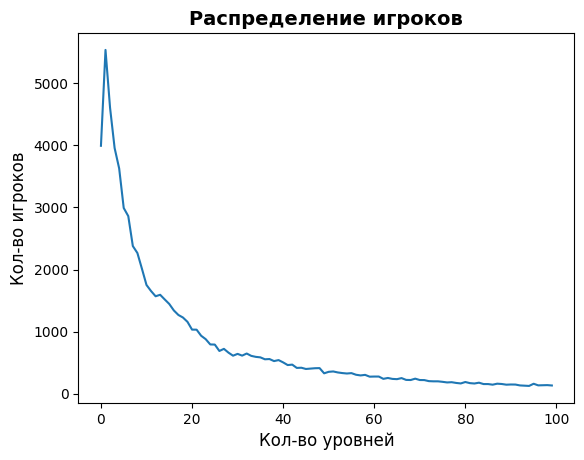

In [6]:
plot_df = df.groupby('sum_gamerounds')['userid'].count()
ax = plot_df.head(100).plot()
plt.title('Распределение игроков', fontweight='bold', size=14)
plt.xlabel('Кол-во уровней', size=12)
plt.ylabel('Кол-во игроков', size=12)
plt.show()

На графике видно некоторые игроки установив игру ни разу не играли в неё. Посчитаем их кол-во.

In [7]:
df[df['sum_gamerounds']==0]['userid'].count()

3994

*Не так уж и много*

Посмотрим на Процент удержания игроков спустя 1 и 7 дней.

In [8]:
df_retention = df[['retention_1','retention_7']].mean()*100
print(f'Удержание спустя 1 день {round(df_retention[0], 2)}%')
print(f'Удержание спустя 7 дней {round(df_retention[1], 2)}%')

Удержание спустя 1 день 44.52%
Удержание спустя 7 дней 18.61%


*Почти половина(44.52%) играков возвращается на следующий день после первого запуска и 18.61% возвращаются спустя 7 дней.*

Теперь посмотрим на эти показатели в группах

In [9]:
df_ab = df.groupby('version').agg({'userid':'count', 
                                   'sum_gamerounds': 'sum', 
                                   'retention_1': 'mean', 
                                   'retention_7': 'mean'})
df_ab

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,2344795,0.448188,0.190201
gate_40,45489,2333530,0.442283,0.182000


* *Заметно уменьшение одно дневного удержания игроков у группы с воротами на 40м уровне(44.23%), по сравнению с группой где ворота находяться на 30м(44.23%).*
* *Также уменьшение заметно у семи дневного ужержания(`gate_30` — 19.02% и `gate_40` — 18.2%)*
* *Это небольшое изменение, но даже небольшие изменения в удержании могут иметь большое значение. Но хотя и видна в разнице данных, нельзя быть увереным в том, что ворота на уровне 40 в будущем будут хуже?*

Для того что бы получить уверенность в этих показателях удержания, буду использовать бутстреп.

### A/B-тест с бутстрапом

Посчитаем 500 средних для случайных выборок каждой и создадим датафрейм с новыми данными.

In [10]:
# Создадим два списка.
boot_1d = []
boot_7d = []

# Возьмём случайную выборку и посчитаем среднее. Добавим в ранее созданые списки.
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean_1)

    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean_7)

# Слелаем из списков пандас датафрейм.
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)


Построим графики и посмотрим что получилось.

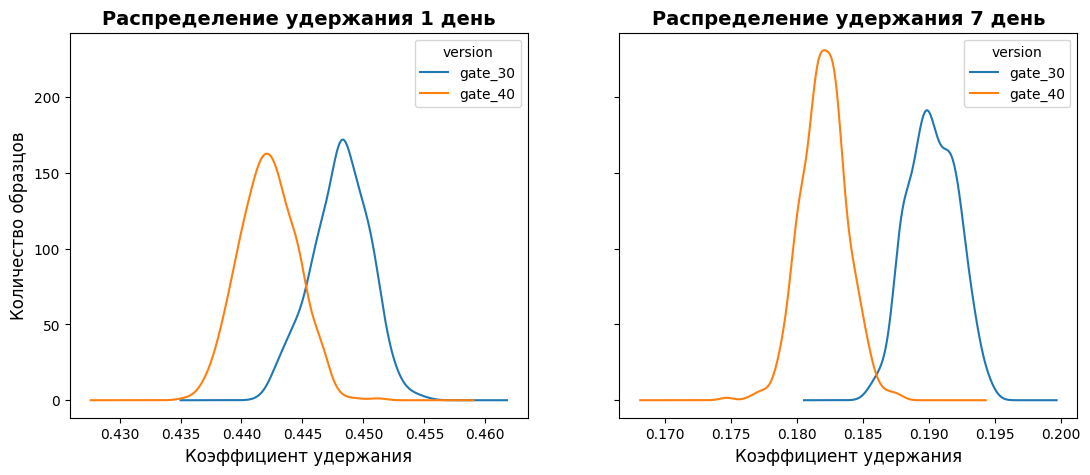

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel('Коэффициент удержания', size=12)
ax1.set_ylabel('Количество образцов',size=12)
ax1.set_title('Распределение удержания 1 день', fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel('Коэффициент удержания',size=12)
ax2.set_title('Распределение удержания 7 день', fontweight="bold",size=14)
plt.show()

Эти два распределения, представляют собой неопределенность относительно того, каким может быть 1-дневное и 7-дневное удержание для двух групп A/B. Взглянув на графики, видно, что, есть некоторая разница, хотя и небольшая. 

Посмотрим на разницу.

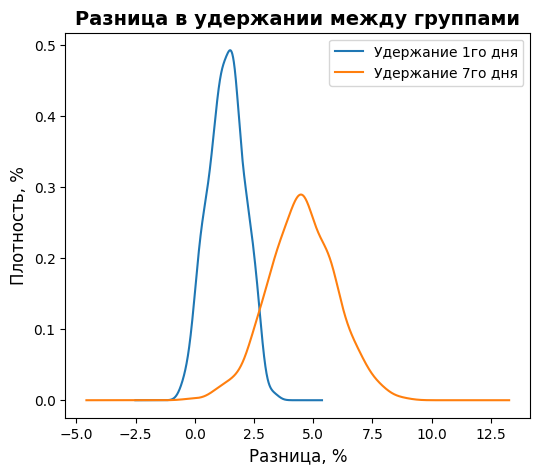

In [12]:
# Добавим столбец с процентной разностью для каждого датафрейма.
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, label = 'Удержание 1го дня')
boot_7d['diff'].plot.kde(ax=ax1, label = 'Удержание 7го дня')
ax1.set_xlabel('Разница, %',size=12)
ax1.set_ylabel('Плотность, %',size=12)
ax1.set_title('Разница в удержании между группами', fontweight="bold", size=14)
plt.legend()
plt.show()

Тут видно, что вероятная процентная разница составляет около 1–2% для 1-дневного удержания. Для 7-дневного удержания вероятная процентная разница составляет около 5%. Большая часть распределения выше 0% в пользу ворот на уровне 30. Но какова вероятность того, что разница окажется выше 0%? Посчитаем.

In [13]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print(f'Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: {round(prob_1,2)*100}%')
print(f'Вероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: {round(prob_7, 2)*100}%')

Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: 97.0%
Вероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: 100.0%


## Вывод:

Результат бутстапа говорит нам о том, что существуют убедительные доказательства с вероятностью 97.0% того, что 1-дневное удержание выше, когда ворота находится на уровне 30, чем когда они находится на уровне 40.

Вывод таков: если мы хотим поддерживать высокий уровень удержания — как 1-дневный, так и 7-дневный, — нам не следует перемещать порог с уровня 30 на уровень 40. Конечно, есть и другие показатели, на которые можно обратить внимание, например, количество сыгранных игровых раундов или количество внутриигровых покупок, совершенных двумя AB-группами. Но удержание — один из наиболее важных показателей.
